# Predictive Maintenance

## Abstract

In modern industrial environments, unexpected equipment failures can lead to costly production interruptions, reduced product quality, and inefficient resource utilization. Traditional maintenance strategies—such as corrective or scheduled preventive maintenance—often result in either excessive downtime or unnecessary part replacements. Predictive maintenance (PdM) addresses these inefficiencies by leveraging data-driven models to predict when a failure is likely to occur, enabling maintenance actions to be performed only when necessary.

Predictive maintenance represents a supervised learning problem, typically formulated as either:
- Classification: Predicting whether equipment will fail within a specific time window (binary or multi-class classification)
- Regression: Estimating Remaining Useful Life (RUL) as a continuous variable
- Anomaly Detection: Identifying unusual patterns that deviate from normal operating conditions

The motivation behind this work lies in demonstrating how predictive analytics can transform maintenance management from a reactive process into a proactive, optimized decision-making framework. The project contributes to the broader goal of improving industrial reliability, reducing operational costs, and supporting the ongoing digital transformation toward Industry 4.0.

## Introduction

Predictive maintenance (PdM) offers a more advanced, data-driven alternative. By monitoring equipment conditions through sensors and operational data, PdM aims to anticipate failures before they occur, allowing maintenance teams to act at the optimal time. This approach not only improves system reliability but also reduces downtime, extends machine lifespan, and supports cost-efficient maintenance planning. The growing availability of industrial Internet of Things (IIoT) sensors and real-time data collection technologies has made predictive maintenance an essential component of the  Industry — the ongoing digital transformation of manufacturing and production systems.

The purpose of this project is to apply machine learning techniques to predict equipment failures using the AI4I 2020 Predictive Maintenance Dataset. The study investigates how statistical and algorithmic models can be used to recognize failure patterns based on process variables such as temperature, rotational speed, torque, and tool wear. By employing ensemble learning methods — specifically Random Forest, XGBoost and stacking them — the project aims to develop accurate and interpretable predictive models capable of supporting intelligent maintenance decisions.

Through systematic data analysis, model development, and performance evaluation, this project seeks to demonstrate the value of predictive analytics in industrial maintenance management. The results are expected to highlight how data-driven decision-making can transform maintenance strategies from reactive to proactive, contributing to improved operational reliability and alignment with modern industrial innovation standards.

## Objectives
1. Develop a models for predicting machine failure.
2. Stacking the models for best result
3. Engineer-interpretable explanations to identify leading indicators associated with failures.
   


## Methodology 

This study employs a quantitative, data-driven approach utilizing supervised machine learning techniques. The methodology integrates domain knowledge from mechanical engineering and reliability theory with advanced statistical learning methods to develop robust predictive models.

Based on current best practices in industrial predictive maintenance, this project will implement ensemble learning methods, specifically Random Forest and XGBoost algorithms, which have demonstrated superior performance in predictive maintenance applications.

Ensemble learning combines multiple base models to create a stronger composite model. This approach is particularly suited for predictive maintenance because:
1. Industrial sensor data contains measurement noise, outliers, and artifacts. Ensemble methods average predictions across multiple models, reducing the impact of individual noisy observations.
2. Equipment degradation involves complex, non-linear interactions between operating conditions. Tree-based ensembles naturally capture these non-linearities without requiring explicit feature transformation.
3. Ensemble methods automatically identify important feature interactions. For example, high temperature may only indicate failure risk when combined with specific vibration patterns.


## Data Preprocessing

Data preprocessing is to prepare the dataset for reliable and efficient modeling. It ensures that the data is clean, consistent, and in a suitable format for the algorithms to learn meaningful patterns. Preprocessing reduces noise, handles missing or inconsistent values, and transforms variables so that the models can perform at their best.

In this case, preprocessing should focus on basic but essential steps rather than heavy transformation, as both chosen algorithms handle nonlinearity and feature scaling well. Categorical features should be encoded numerically, and missing values should be imputed or removed if necessary. Outliers can be examined but generally do not need removal unless they result from errors.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, train_test_split, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
import optuna
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (f1_score, make_scorer, confusion_matrix, classification_report, roc_curve, precision_recall_curve, roc_auc_score, 
                    average_precision_score, balanced_accuracy_score, matthews_corrcoef
                    )
import shap
from sklearn.inspection import permutation_importance


In [2]:
df = pd.read_csv("data/ai4i2020.csv")
df1 = pd.read_csv("data/aps_failure_training_set.csv")
df1_test = pd.read_csv("data/aps_failure_test_set.csv")



#Renaming all columns to be snake case according to the best practices. 
rename_mapper = {
    'UDI': 'udi',
    'Product ID': 'product_id',
    'Type': 'type',
    'Air temperature [K]': 'air_temp_k',
    'Process temperature [K]': 'process_temp_k',
    'Rotational speed [rpm]': 'rotational_speed_rpm',
    'Torque [Nm]': 'torque_nm',
    'Tool wear [min]': 'tool_wear_min',
    'Machine failure': 'failure',
    'TWF': 'twf', #tool wear failure
    'HDF': 'hdf', #heat dissipation failure 
    'PWF': 'pwf', #power failure
    'OSF': 'osf', #overstrain failure
    'RNF': 'rnf' #random failures
}


df.rename(columns= rename_mapper, inplace=True)



# Checking for duplicates, because duplicates can bias the model and reduce its generalization ability.
print("Duplicate values")
print(df.duplicated().sum())
print()

#Checking for missing values
print("Missing values")
print(df.isnull().sum())
print()


#Checking the unique values in columns
#Columns with less unique values add noise and can overfit. Checking the binary features.

print("Unique values")
print(df.nunique())
print()






Duplicate values
0

Missing values
udi                     0
product_id              0
type                    0
air_temp_k              0
process_temp_k          0
rotational_speed_rpm    0
torque_nm               0
tool_wear_min           0
failure                 0
twf                     0
hdf                     0
pwf                     0
osf                     0
rnf                     0
dtype: int64

Unique values
udi                     10000
product_id              10000
type                        3
air_temp_k                 93
process_temp_k             82
rotational_speed_rpm      941
torque_nm                 577
tool_wear_min             246
failure                     2
twf                         2
hdf                         2
pwf                         2
osf                         2
rnf                         2
dtype: int64



In [3]:
# Removing the columns, they dont bring any valuable information

if 'udi' in df.columns:
    df.drop(columns=['udi'],inplace=True)
if 'product_id' in df.columns:
 df.drop(columns=['product_id'],inplace=True)

# One hot encoding - converting quality types into numerical
if 'type' in df.columns:
    df = pd.get_dummies(df, columns = ['type'])


In [4]:
# Training set APS
# Checking for duplicates
print("Duplicate values")
print(df1.duplicated().sum())
print()

#Checking for missing values
print("Missing values")
print(df1.isnull().sum())
print()


#Checking the unique values in columns
print("Unique values")
print(df1.nunique())


#Clean the whitespace
df1.columns = [c.strip() for c in df1.columns]

df1 = df1.replace(["na", "NA"], np.nan)


#Transform to nummeric
df1["class"] = df1["class"].astype(str).str.lower()
df1["class"] = df1["class"].map({"neg": 0, "pos": 1})






# Test set APS
# Checking for duplicates
print("Duplicate values")
print(df1_test.duplicated().sum())
print()

#Checking for missing values
print("Missing values")
print(df1_test.isnull().sum())
print()


#Checking the unique values in columns
print("Unique values")
print(df1_test.nunique())


#Clean the whitespace
df1_test.columns = [c.strip() for c in df1_test.columns]

df1_test = df1_test.replace(["na", "NA"], np.nan)


#Transform to nummeric
df1_test["class"] = df1_test["class"].astype(str).str.lower()
df1_test["class"] = df1_test["class"].map({"neg": 0, "pos": 1})


Duplicate values
0

Missing values
class     0
aa_000    0
ab_000    0
ac_000    0
ad_000    0
         ..
ee_007    0
ee_008    0
ee_009    0
ef_000    0
eg_000    0
Length: 171, dtype: int64

Unique values
class         2
aa_000    22095
ab_000       30
ac_000     2062
ad_000     1887
          ...  
ee_007    30470
ee_008    24214
ee_009     9725
ef_000       29
eg_000       50
Length: 171, dtype: int64
Duplicate values
0

Missing values
class     0
aa_000    0
ab_000    0
ac_000    0
ad_000    0
         ..
ee_007    0
ee_008    0
ee_009    0
ef_000    0
eg_000    0
Length: 171, dtype: int64

Unique values
class         2
aa_000     9237
ab_000       19
ac_000     1312
ad_000     1203
          ...  
ee_007    10272
ee_008     8315
ee_009     4043
ef_000       13
eg_000       25
Length: 171, dtype: int64


## Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) helps prevent the “garbage in, garbage out” problem by ensuring that the data used for modeling is meaningful and reliable. It identifies which sensors provide valuable information and which generate mostly noise. EDA also reveals whether failure patterns are present in the raw data, indicates what types of preprocessing are required, and highlights the features most likely to contribute to accurate failure prediction.
1. Distribution Analysis - Understanding the statistical properties of each feature
2. Correlation Analysis - Identifying relationships between sensors and failure events



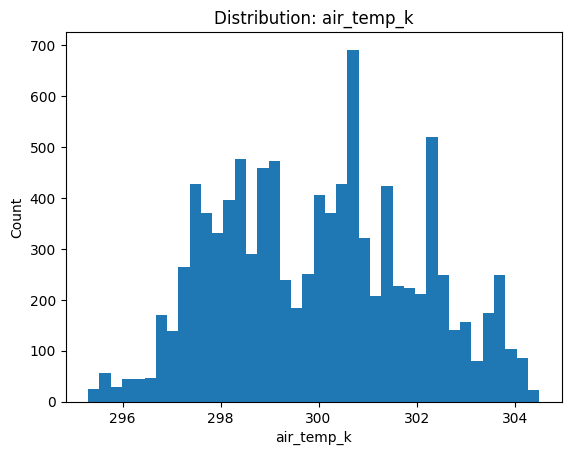

count    10000.000000
mean       300.004930
std          2.000259
min        295.300000
25%        298.300000
50%        300.100000
75%        301.500000
max        304.500000
Name: air_temp_k, dtype: float64
Skew: 0.11427392052155025
Kurt: 2.1640383274225314
Min: 295.30
Max: 304.50
Range: 9.20
Skewness analysis - Distribution is approximately symmetric

Kurtosis analysis - PLATYKURTIC: Flatter peak, thinner tails than normal. Fewer outliers are expected


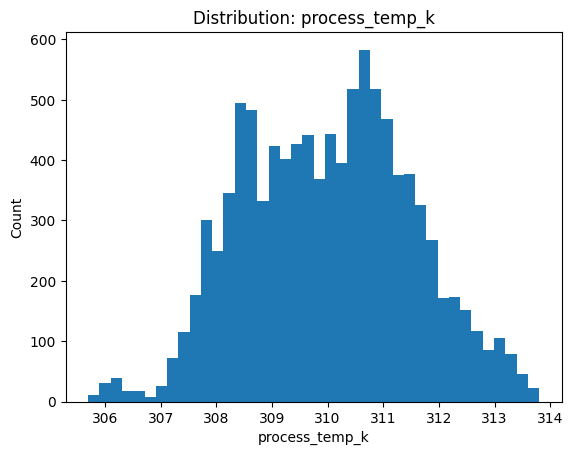

count    10000.000000
mean       310.005560
std          1.483734
min        305.700000
25%        308.800000
50%        310.100000
75%        311.100000
max        313.800000
Name: process_temp_k, dtype: float64
Skew: 0.015027267769343768
Kurt: 2.5002656349838603
Min: 305.70
Max: 313.80
Range: 8.10
Skewness analysis - Distribution is approximately symmetric

Kurtosis analysis - PLATYKURTIC: Flatter peak, thinner tails than normal. Fewer outliers are expected


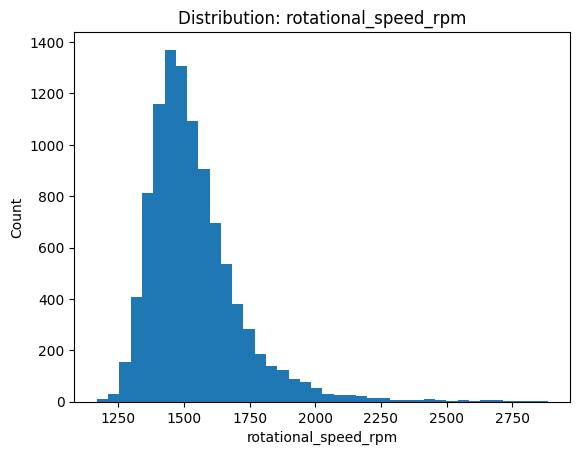

count    10000.000000
mean      1538.776100
std        179.284096
min       1168.000000
25%       1423.000000
50%       1503.000000
75%       1612.000000
max       2886.000000
Name: rotational_speed_rpm, dtype: float64
Skew: 1.993171004713752
Kurt: 10.392944899246482
Min: 1168.00
Max: 2886.00
Range: 1718.00
Skewness analysis - Distribution is strong right skewness
Kurtosis analysis - LEPTOKURTIC: Sharper peak, fatter tails than normal. More outliers expected


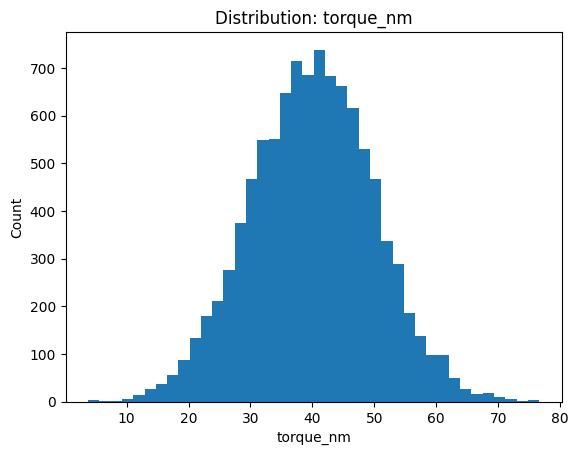

count    10000.000000
mean        39.986910
std          9.968934
min          3.800000
25%         33.200000
50%         40.100000
75%         46.800000
max         76.600000
Name: torque_nm, dtype: float64
Skew: -0.009516595840058577
Kurt: 2.9867593859829777
Min: 3.80
Max: 76.60
Range: 72.80
Skewness analysis - Distribution is approximately symmetric
Kurtosis analysis - MESOKURTIC: Normal distribution


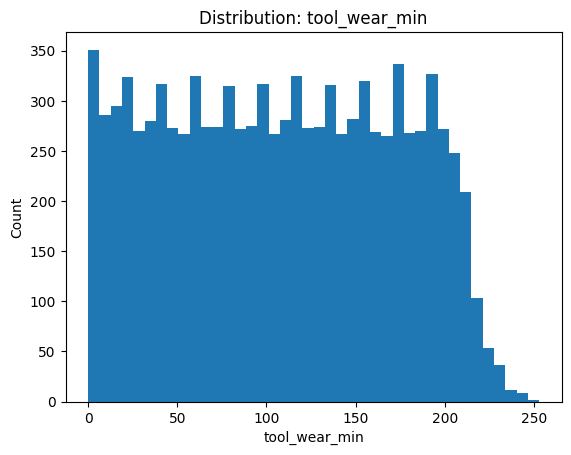

count    10000.000000
mean       107.951000
std         63.654147
min          0.000000
25%         53.000000
50%        108.000000
75%        162.000000
max        253.000000
Name: tool_wear_min, dtype: float64
Skew: 0.027292239050452523
Kurt: 1.833262868421945
Min: 0.00
Max: 253.00
Range: 253.00
Skewness analysis - Distribution is approximately symmetric

Kurtosis analysis - PLATYKURTIC: Flatter peak, thinner tails than normal. Fewer outliers are expected


In [5]:
#Distributions
'''
Distribution analysis are performed for multiple reasons: 
- describe where the most data lies (which quartiles)
- what is the variation of the measurements
- determing whether the process variables are stable
- defining the shape of the distributions
- defining abnormal machine behaviour or errors
- ensuring dataset is reliable and representative
'''
def histograms(data, bins = 40):
    plt.figure ()
    plt.hist(df[data],bins = bins)
    plt.title(f"Distribution: {data}")
    plt.xlabel(data)
    plt.ylabel("Count")
    plt.show()

    skew = df[data].skew()
    kurt = df[data].kurt() + 3 #Pandas return excess kurt, calculating the actual
    print(df[data].describe())
    print(f"Skew: {skew}")
    print (f"Kurt: {kurt}")
    print(f"Min: {df[data].min():.2f}")
    print(f"Max: {df[data].max():.2f}")
    print(f"Range: {df[data].max() - df[data].min():.2f}")

    # Skewness interpretation
    if -0.5 <= skew <= 0.5:
        print(f"Skewness analysis - Distribution is approximately symmetric")
    elif 0.5 < skew <= 1:
        print(f"Skewness analysis - Distribution is moderate right skewness")
    elif skew > 1:
        print(f"Skewness analysis - Distribution is strong right skewness")
    elif -1 <= skew < -0.5:
        print(f"Skewness analysis - Distribution is moderate left skewness")
    elif skew < -1:
        print(f"Skewness analysis - Distribution is strong left skewness")

    if  2.8 <= kurt <= 3.2:
        print(f"Kurtosis analysis - MESOKURTIC: Normal distribution")
    elif kurt > 3.2:
        print(f"Kurtosis analysis - LEPTOKURTIC: Sharper peak, fatter tails than normal. More outliers expected")
    elif kurt < 2.8:
        print(f"")
        print(f"Kurtosis analysis - PLATYKURTIC: Flatter peak, thinner tails than normal. Fewer outliers are expected")




for column in ['air_temp_k', 'process_temp_k','rotational_speed_rpm', 'torque_nm', 'tool_wear_min']:
    histograms(column)

### Conclusion
The dataset appears physically consistent and typical for a predictive maintenance problem. Air and process temperatures are stable and normally distributed, indicating a controlled environment. Most likely they are not strong direct predictors of failure but provide useful context—particularly the temperature difference, which can signal thermal stress. Rotational speed and torque show much more variation and are directly related to machine load and stress. Rotational speed is strongly right-skewed, suggesting occasional high-speed operations that could accelerate wear or trigger failures. Torque is approximately normal but interacts closely with speed, meaning combined high torque and speed likely indicate high mechanical stress. Tool wear increases steadily and is the most direct measure of component aging and failure risk.

he relationships between these features are nonlinear and interactive, making tree-based models such as XGBoost or Random Forest particularly well suited to capture them.

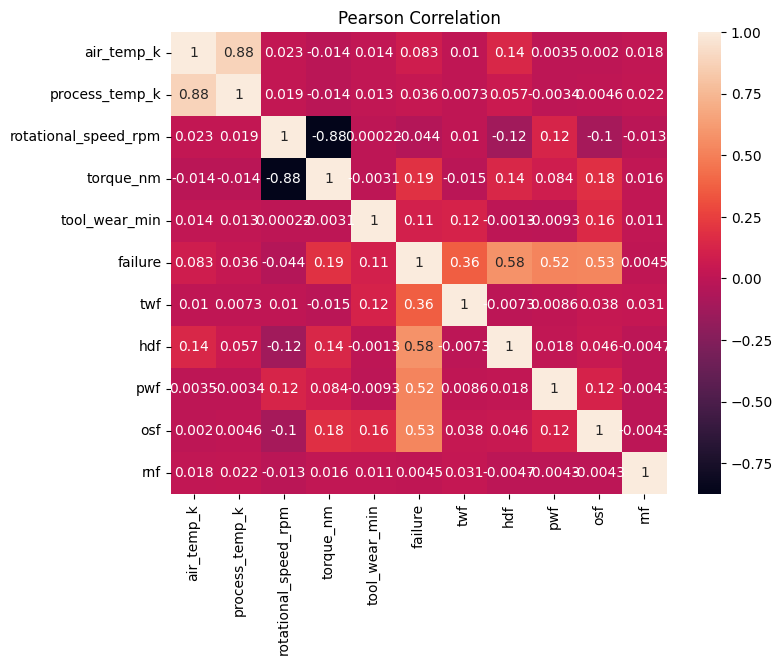

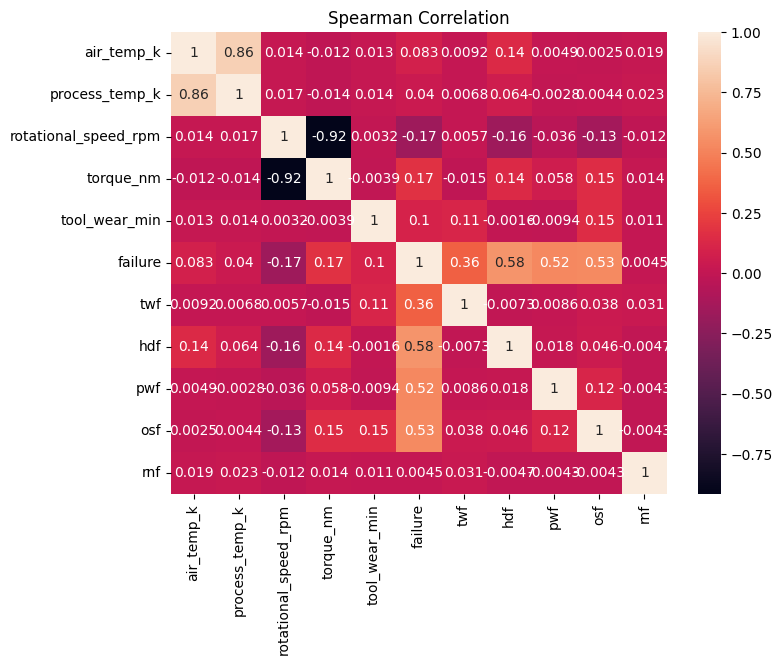

Strong correlation found on both methods:
air_temp_k vs process_temp_k
Pearson:  0.876
Spearman: 0.864

rotational_speed_rpm vs torque_nm
Pearson:  -0.875
Spearman: -0.916

Moderate correlation found on both methods:
failure vs hdf
Pearson:  0.576
Spearman: 0.576

failure vs pwf
Pearson:  0.523
Spearman: 0.523

failure vs osf
Pearson:  0.531
Spearman: 0.531



In [10]:
'''The correlation matrix shows which variables are closely related. 
In predictive maintenance, a strong correlation might indicate a mechanical dependency.
It also can validating expected physical relationships or revealing unexpected dependencies.
'''

corr_df = df[['air_temp_k', 'process_temp_k','rotational_speed_rpm', 'torque_nm', 'tool_wear_min','failure', 'twf','hdf', 'pwf', 'osf', 'rnf']]
corr_matrix = corr_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True)
plt.title('Pearson Correlation')
plt.show()

plt.figure(figsize=(8, 6))
corr_matrix_spearman = corr_df.corr(method="spearman")
sns.heatmap(corr_matrix_spearman, annot=True)
plt.title('Spearman Correlation')
plt.show()


all_pairs = [(corr_matrix.columns[i], corr_matrix.columns[j], 
              corr_matrix.iloc[i, j], corr_matrix_spearman.iloc[i, j])
             for i in range(len(corr_matrix.columns))
             for j in range(i+1, len(corr_matrix.columns))]

confirmed_strong = [(var1, var2, pearson, spearman) 
                    for var1, var2, pearson, spearman in all_pairs 
                    if abs(pearson) > 0.7 and abs(spearman) > 0.7]

moderate = [(var1, var2, pearson, spearman) 
            for var1, var2, pearson, spearman in all_pairs 
            if 0.4 < abs(pearson) <= 0.7 and 0.4 < abs(spearman) <= 0.7]


print("Strong correlation found on both methods:")
for var1, var2, p_corr, s_corr in confirmed_strong:        
    print(f"{var1} vs {var2}")
    print(f"Pearson:  {p_corr:.3f}")
    print(f"Spearman: {s_corr:.3f}")
    print()


print("Moderate correlation found on both methods:")
for var11, var22, p_corr_m, s_corr_m in moderate:        
    print(f"{var11} vs {var22}")
    print(f"Pearson:  {p_corr_m:.3f}")
    print(f"Spearman: {s_corr_m:.3f}")
    print()



### Conclusion
The correlation analysis reveals several strong and meaningful relationships within the dataset. Air temperature and process temperature show a very strong positive correlation, indicating that the process temperature closely follows ambient conditions—likely because the machine’s operating heat is influenced by surrounding air. Similarly, rotational speed and torque show a strong negative correlation, suggesting that when the machine runs faster, the torque required decreases, and vice versa. This inverse relationship is typical in systems where higher speeds reduce mechanical resistance per revolution.

Moderate positive correlations between overall machine failure and specific failure types (HDF, PWF, OSF) indicate that these features contribute significantly to the overall failure label. In other words, when these specific failures occur, they strongly influence the machine’s total failure status.

In [11]:
'''
Counts of failures shows whether they are rare compared to normal operations.
In predictive maintenance, imbalance is common — most samples represent 
normal machine behavior, while failures are scarce. By observing which failure types
are most or least frequent, it becomes clear which issues dominate in the dataset.



Because the dataset is highly imbalanced, several techniques should be applied:

Matthews Correlation Coefficient (MCC):
A robust performance metric that remains reliable even when classes are imbalanced.

Precision–Recall (PR) Curve:
Focuses on performance for the minority class and is more informative than ROC curves in imbalanced settings.

F1 Score:
Harmonic mean of precision and recall; useful when false negatives and false positives both matter.
With F1 could avoiding false alarms. Recall can show failure, but with accuracy 5%, which is considered as false alarm
β1 = precision and recall are equally important, β > 1 → recall is more important

recall - model ability to catch failure. From all failures how manu are predicted corectly


Class Weights:
Increases the penalty for misclassifying minority-class samples so the model treats them as more important.

Select an Appropriate Model (avoid AdaBoost):
Some models, like AdaBoost, struggle with severe imbalance. Use models more robust to imbalance (e.g., Random Forest, Gradient Boosting, XGBoost, SVM with class weights).

Use Model Probability Outputs (Adjust Decision Threshold):
Instead of using the default 0.5 threshold, tune the threshold to improve recall or F1 for the minority class.

Stratified Sampling:
Ensures that each training/validation fold maintains the original class distribution.

Cross-Validation:
Improves reliability of evaluation by testing the model on multiple balanced splits.

Feature Engineering:
Creating informative features can help the model better separate classes even when data is imbalanced.
'''

# print( df['type'].value_counts())
print()
for c in ['failure','twf','hdf', 'pwf', 'osf', 'rnf']:
    if c in df.columns:
        print(df[c].value_counts())


failure
0    9661
1     339
Name: count, dtype: int64
twf
0    9954
1      46
Name: count, dtype: int64
hdf
0    9885
1     115
Name: count, dtype: int64
pwf
0    9905
1      95
Name: count, dtype: int64
osf
0    9902
1      98
Name: count, dtype: int64
rnf
0    9981
1      19
Name: count, dtype: int64


### Conclusion
Dataset is heavily imbalanced. The failure modes overlap witht he failure, meaning they should be excluded from the prediction to avoiding leakage. The classification models expect to bias towards majority thats why some extra measures should be taken.

## Feature Selection and Engineering

Machine learning algorithms identify statistical patterns, but they cannot invent physics. Feature engineering injects domain knowledge about physical degradation mechanisms into the model.

Predictive maintenance data often contain redundant or irrelevant features. Both selected models inherently support feature importance evaluation, which helps identify the most influential predictors of machine failure.

In [12]:
'''
A higher difference indicates that the machine is operating under higher heat stress,
which can accelerate wear or cause overheating-related failures. The heat load could be caused by problems with bearing or lubrication
'''
df['delta_temp'] = df['process_temp_k'] - df['air_temp_k']


'''
High load conditions (more power) increase mechanical stress and can lead to overstrain or heat-related failures.
'''
# Power = Torque (Nm) × Angular Velocity (rad/s)
df['power_w'] = df['torque_nm'] * (df['rotational_speed_rpm'] * 2 * np.pi / 60)


'''
A higher torque-to-speed ratio indicates that the machine produces more load at lower speed.
This often means higher friction or resistance, which can signal mechanical wear or imbalance.
'''
df['load_ratio'] = df['torque_nm'] / df['rotational_speed_rpm']



'''
Quantifies how quickly the tool wears for each unit of torque.
A rising wear rate per torque unit indicates mechanical fatigue or material deterioration.
'''
df['wear_rate_per_torque'] = df['tool_wear_min'] / (df['torque_nm'] + 1e-3)

### Conclusion
The engineered features capture key physical indicators of machine health and strongly support failure prediction. Together, these features translate raw sensor readings into meaningful measures of heat, load, and wear — allowing the model to better distinguish normal operation from conditions leading to failure.

## Training

In [9]:
'''
Stratified splitting ensures that both training and validation sets keep the same proportion 
of failures and normal cases as the original data. This is crucial for imbalanced datasets 
like predictive maintenance, where failures are rare. It prevents biased training, 
guarantees that each split contains enough failure examples, and makes performance metrics 
like F1 and recall more reliable and consistent.
'''


# Droping the target and failure columns will avoid data leackage
X = df.drop(columns=['failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf'])  
y = df['failure']

# Splitting for the final training
X_tr, X_test_df, y_tr, y_test_df  = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
print("Y shape (first split):", y_tr.shape)
print("X shape (first split):", X_tr.shape)



# Spliting for validation sample
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_tr, y_tr, test_size=0.1, stratify=y_tr, random_state=42)

print("Y shape (second split):", y_train_df.shape)
print("X shape (second split):", X_train_df.shape)


#Dataset APS
y_tr_df1 = df1["class"].astype(int)    
X_tr_df1 = df1.drop(columns=["class"] )

X_train_df1, X_val_df1, y_train_df1, y_val_df1  = train_test_split(X_tr_df1, y_tr_df1, test_size=0.1, stratify=y_tr_df1, random_state=42)

print("Y shape APS:", y_tr_df1.shape)
print("X shape APS:", X_tr_df1.shape)
print("Y shape APS (after):", y_train_df1.shape)
print("X shape APS (after):", X_train_df1.shape)

y_test_df1 = df1_test["class"].astype(int)   
X_test_df1 = df1_test.drop(columns=["class"] )

Y shape (first split): (9000,)
X shape (first split): (9000, 8)
Y shape (second split): (8100,)
X shape (second split): (8100, 8)
Y shape APS: (60000,)
X shape APS: (60000, 170)
Y shape APS (after): (54000,)
X shape APS (after): (54000, 170)


## Random Forest Algorithm

Random Forest is an ensemble machine learning algorithm that operates by building multiple decision trees during training and outputting the average of predictions from individual trees for regression tasks, or the majority vote for classification tasks. It employs bootstrap aggregating (bagging), where each tree is trained on a random subset of data with random feature selection at each split and their predictions are averaged (or voted)

Why:
1. Random Forest's ability to train trees in parallel contributes significantly to its speed.
2. Industrial datasets contain both continuous sensor readings and categorical variables. Random Forest handles this heterogeneity without extensive preprocessing.
3. The algorithm provides natural feature importance rankings.
4. Random Forest is less likely to overfit than a single decision tree because it averages multiple trees to give a final prediction. Anywhay the chance of overfitting is still very high, which requires additional techniquies to prevent it.
5. Unlike many algorithms, Random Forest does not require normalization or standardization.
6. It delivers strong baseline performance with minimal hyperparameter optimization.

In [139]:
'''
Hyperparameter tuning is used because it helps automatically 
find the best set of parameters that maximize model’s performance — efficiently and intelligently.

Cross-validation ensures that the model performance is tested on several different splits of the data.

Combining hyperparameter tuning, and cross-validation makes the training process fair and effective. 
Cross-validation ensures reliable evaluation, and hyperparameter tuning selects 
the most robust model. Together, they produce a model that can detect failures accurately and consistently.

Optuna is used instead of grid search or random search because it is faster
and more efficient. Grid search tests every possible parameter combination,
which is slow and wasteful, while random search is quicker but still guesses blindly. 
Optuna uses intelligent optimization — it learns from past trials using Bayesian methods
to focus on the most promising parameter values. It can also stop unpromising runs early (pruning),
saving time and resources. As a result, Optuna finds better hyperparameters faster and with
fewer experiments, leading to higher model performance and lower computational cost.

Recommended values for min_samples_leaf
< 10k samples	5–20
10k–100k	1–10
> 100k	1–5
'''


def rf_objective(trial):

    max_k = X_train_df.shape[1]          
    min_k = max(3, max_k // 4) 
    k_keep = trial.suggest_int("k_keep", min_k , max_k)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 700),#200-1000
        "max_depth": trial.suggest_int("max_depth", 2, 7),  # maximum number of splits from root to leaf
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 20),  # Should be larger then min_samples_leaf
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20),  # 5-25 #each leaf has enough data to make a reliable prediction.
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),  
        "bootstrap": True,  
        "class_weight": "balanced", #adjusts the weight of each class INVERSLY proportional to how often that class appears in the dataset
        "random_state": 42,
        "n_jobs": -1,
    }

 """ 
When class weights is used, don’t need oversampling or undersampling because the model 
automatically pays more attention to the minority class (failures) during training, without modifying the actual dataset.
Oversampling couse overfitting, noise, longer training

 """
    pipeline = ImbPipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("select", SelectKBest(score_func=mutual_info_classif, k=k_keep)),
        # ("smote", BorderlineSMOTE(random_state=42)),  # Removed. Getting better results with class_weight instead. Oversampling couse overfitting, noise, longer training
        ("clf", RandomForestClassifier(**params))
    ])

    #Cross validation
   
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train_df, y_train_df, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()




In [30]:
study_rf = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

study_rf.optimize(
    lambda trial: rf_objective(trial),
    n_trials=50,
    show_progress_bar=True
)

print("Best RF F1:", study_rf.best_value)
print("Best RF params:", study_rf.best_trial.params)


[I 2025-10-19 16:55:47,694] A new study created in memory with name: no-name-538ead2d-b824-455b-ba3b-c2f3e49c40b7


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-19 16:55:48,705] Trial 0 finished with value: 0.2930033217858401 and parameters: {'k_keep': 5, 'n_estimators': 159, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 21, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.2930033217858401.
[I 2025-10-19 16:55:50,036] Trial 1 finished with value: 0.5041283716283717 and parameters: {'k_keep': 6, 'n_estimators': 261, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 24, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5041283716283717.
[I 2025-10-19 16:55:51,485] Trial 2 finished with value: 0.4991469115282971 and parameters: {'k_keep': 11, 'n_estimators': 266, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5041283716283717.
[I 2025-10-19 16:55:54,037] Trial 3 finished with value: 0.43250842207306306 and parameters: {'k_keep': 6, 'n_estimators': 662, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features

In [14]:
# Original dataset
#Best RF F1: 0.6939599152959146
#Best RF params: {'k_keep': 9, 'n_estimators': 302, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}

#Use parameters direct from Optuna

#best_rf_params = study_rf.best_params
#k_rf_best = best_rf_params.pop("k_keep")



#Use found parameters from Optuna, but hardcoded
k_rf_best = 8  # from search

best_rf_params = {
    "n_estimators": 302,
    "max_depth": 7,
    "min_samples_split": 10,
    "min_samples_leaf": 6,
    "max_features": "sqrt",
}

final_rf_pipeline = ImbPipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("select", SelectKBest(mutual_info_classif, k=k_rf_best)),
    ("clf", RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1))
])



final_rf_pipeline.fit(X_train_df, y_train_df)


#Fast Evaluation
y_train_pred = final_rf_pipeline.predict(X_train_df)
print("Training F1:", f1_score(y_train_df, y_train_pred))

y_val_pred = final_rf_pipeline.predict(X_val_df)
print("Validation F1:", f1_score(y_val_df, y_val_pred))



Training F1: 0.5449871465295629
Validation F1: 0.38095238095238093


In [18]:
# Validation daset

final_rf_pipeline_df1 = ImbPipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("select", SelectKBest(score_func=mutual_info_classif, k=k_rf_best)),
   # ("smote", BorderlineSMOTE(random_state=42)),
    ("clf", RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)),
])


final_rf_pipeline_df1.fit(X_train_df1, y_train_df1)

# Training F1
y_train_pred_df1 = final_rf_pipeline_df1.predict(X_train_df1)
print("Training F1 (APS): ", f1_score(y_train_df1, y_train_pred_df1))

# Validation F1
y_val_pred_df1 = final_rf_pipeline_df1.predict(X_val_df1)
print("Validation F1 (APS): ", f1_score(y_val_df1, y_val_pred_df1))



Training F1 (APS):  0.622478386167147
Validation F1 (APS):  0.5384615384615384


### Conclusion
The Random Forest model performed consistently on the primary dataset with very small gap between training and validation sample, indicating good generalization and a well-balanced fit. To further assess model robustness and potential overfitting, the same tuned parameters were applied to the structurally different dataset without additional feature engineering. The lower performance on this dataset confirmed that while the model generalizes well within its original domain, its effectiveness decreases when applied to data with different structure and feature distributions.

The results show mild overfitting, which is acceptable and indicates that the model is learning meaningful patterns rather than memorizing the data.Overall, the model performs consistently across datasets and is likely well-tuned

## XGBoost Algorithm

XGBoost (Extreme Gradient Boosting) is a highly efficient gradient boosting algorithm that builds trees sequentially, with each new tree correcting errors made by previous ones, incorporating optimizations including built-in regularization (L1 and L2) to prevent overfitting, handling of missing values, and tree pruning.

1) Compute raw score (logit): 

2) Apply sigmoid(binary) or softmax(multy-class): It calculates the probability

3) Apply cross-entropy loss(binary) or categorical cross-entropy(multy-class): measures how wrong the probability is. Punishment depends of the magnitute of the error

4) Compute gradient(g) then Hessian(h)

5) Fit a tree, applying Newton method(g/ h+L2 regularization) then to update z



\begin{align*}
w^* &=
\begin{cases}
0, & \text{if } \Bigl|\sum_i g_i\Bigr| \le \alpha \\[10pt]
-\dfrac{\sum_i g_i - \operatorname{sign}\!\left(\sum_i g_i\right)\alpha}{\sum_i h_i + \lambda}, &
\text{otherwise}
\end{cases} \\[12pt]
g_i &= \frac{\partial L}{\partial f(x_i)} \quad \text{(gradient)} \\[8pt]
h_i &= \frac{\partial^2 L}{\partial f(x_i)^2} \quad \text{(Hessian / curvature)}
\end{align*}

Why:
1. Equipment failures are rare events. XGBoost can handle class imbalance very effectively.
2. It incorporates L1 and L2 regularization directly into its algorithm, with L1 helping in feature selection by shrinking less important coefficients to zero, and L2 penalizing the sum of squares to prevent any single feature from having excessive influence.
3. The model builds trees sequentially where each new tree attempts to correct errors made by previous ones, systematically improving the model's accuracy by focusing on the hardest to predict observations.
4. Industrial sensor data often contains missing values due to sensor failures or communication issues. XGBoost has native support for missing data, learning optimal directions for missing values during training.

In [5]:

def objective_xgb(trial):

    #class imbalance ratio
    neg = (y_train_df == 0).sum() #number of negative samples
    pos = (y_train_df == 1).sum() #number of positive samples
    base_spw = float(neg) / max(1.0, float(pos))


    #how many features to keep
    max_k = X_train_df.shape[1]   #all features in DF       
    min_k = max(3, max_k // 4) #at least 3 or 25% of the features
    k_keep = trial.suggest_int("k_keep", min_k , max_k)

    params = {
        #Initial range is chocen from the default values, then best practices, then trials
        "n_estimators": trial.suggest_int("n_estimators", 100, 400), #Number of boosting trees - More trees → higher capacity but slower and risk of overfitting. If it goes up, learning rate should goes down.
        "max_depth": trial.suggest_int("max_depth", 3, 5), # Max depth of each tree. - Deeper trees learn more complex patterns but can overfit.
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.8, log=True), #Step size for each round. - Smaller mean slower learning, needs more trees but more stable. A lower value helping to prevent overfitting
        
        "subsample": trial.suggest_float("subsample", 0.5, 0.8), #Fraction of training data used per tree. - Adds randomness, helps prevent overfitting.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9), #Fraction of features used per tree. - Reduces correlation between trees, improves generalization.
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.6, 0.9), #controls the fraction of features randomly chosen at each tree split. Lower values - less overfitting, but also less accyracy
        
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 50, log=True),#10, 30   # Min sum of sample weights needed to make a split. - Higher mean fewer splits mean simpler model (regularization).
        "gamma": trial.suggest_float("gamma", 0, 8),#0.0, 0.5   # A node will only split if the improvement (gain) is at least gamma - Higher - Splits only if they yield significant gain (reduces overfitting).
        
        "reg_alpha": trial.suggest_float("reg_alpha", 0.5, 5, log=True),#0.0, 0.8 #L1 regularization on weights. Pushes less important features’ weights toward zero (sparsity). higher - less overfitting
        "reg_lambda": trial.suggest_float("reg_lambda", 5, 200, log=True),#1, 12  #L2 regularization on weights. Smooths weights to prevent overfitting (shrinks large values).
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10), #Max step size per leaf weight update. Stabilizes training for highly imbalanced data.
"""
Regularization
-reduce overfitting
-make the model simpler
-improve generalization
L1 adds a penalty equal to the sum of absolute values of weights:Pushes many weights to exactly zero, Performs automatic feature selection
L2 adds a penalty equal to the sum of squared weights: Weight distribution: smooth, small values, All features remain in the model



"""

        #Balances the importance of positive vs. negative classes. Higher values make the model focus more on the minority class.
        #“Try values for scale_pos_weight around the natural imbalance ratio (±10–20%) and see what works best.”
        # base_spw is the imbalance ratio
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.9 * base_spw, 1.2 * base_spw),

        "max_bin": trial.suggest_int("max_bin", 64, 256),
        
        "device": "cuda", 
        #booster [default= gbtree] - together with tree_method=hist applies Newton's method
        #Uses both gradient (1st derivative) and Hessian (2nd derivative)
        #Instead of walking slowly downhill like gradient descent, Newton’s method uses curvature to jump directly toward the minimum.
       # Measures slope + curvature
        #Calculates exact bottom
        #Jumps there in one step

        #First uses sigmuid function to convert logit into probability then cross entropy
        "objective": "binary:logistic",
        "tree_method": "hist",      
        "random_state": 42,
        "use_label_encoder": False,
        #"eval_metric": "logloss"
        "eval_metric": "aucpr"
    }

    pipeline = ImbPipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("select", SelectKBest(score_func=mutual_info_classif, k=k_keep)),
       # ('smote', BorderlineSMOTE(random_state=42)),
        ('clf', XGBClassifier(**params))
    ])

    # Cross-validation
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train_df, y_train_df, cv=cv, scoring="f1", n_jobs=-1)

    return scores.mean()

# Optuna with pruning
study_xgb = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study_xgb.optimize(objective_xgb, n_trials=50)

print("Best F1:", study_xgb.best_trial.value)
print("Best params:", study_xgb.best_trial.params)






NameError: name 'optuna' is not defined

In [10]:
''' Best hyperparameters from the tunning:
Best F1: 0.7097065885842431
Best params: {'k_keep': 7, 'n_estimators': 343, 'max_depth': 4, 'learning_rate': 0.48196435539859744,
'subsample': 0.5477612186450878, 'colsample_bytree': 0.7910433261576639, 'colsample_bynode': 0.8526800465600031,
'min_child_weight': 10, 'gamma': 1.269946231035461, 'reg_alpha': 0.9113236293312471, 'reg_lambda': 19.347887478852222,
'max_delta_step': 10, 'scale_pos_weight': 26.18924058128448, 'max_bin': 176}
'''

k_keep = 7


best_xgb_params = {
    "n_estimators": 90,
    "max_depth": 4,
    "learning_rate": 0.48196435539859744,
    "subsample": 0.5477612186450878,
    "colsample_bytree": 0.7910433261576639,
    "colsample_bynode": 0.8526800465600031,
    "min_child_weight": 10,
    "gamma": 1.269946231035461,
    "reg_alpha": 0.9113236293312471,
    "reg_lambda": 19.347887478852222,
    "max_delta_step": 10,
    "scale_pos_weight": 26.18924058128448,
    "max_bin": 176,
    "tree_method": "hist",
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "random_state": 42,
    
}


In [11]:
'''
Threshold tuning adjusts how the model decides whether a machine is likely to fail soon based on its predicted probability.
Instead of using a fixed 0.5 cutoff, finding the probability value that best balances catching real failures early (recall) 
and avoiding false maintenance alerts (precision). This ensures maintenance actions are triggered only when the risk is 
high enough — reducing unnecessary interventions while still preventing unexpected downtime.

'''
def best_f1_threshold(y_true, p):
    prec, rec, thr = precision_recall_curve(y_true, p)
    f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
    return float(thr[int(np.nanargmax(f1s))])




#Original daset
#best_xgb_params = study_xgb.best_params
#k_xgb_best = best_xgb_params.pop("k_keep")
k_xgb_best = k_keep


final_xgb_pipeline = ImbPipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("select", SelectKBest(mutual_info_classif, k=k_xgb_best)),
    ('clf', XGBClassifier(**best_xgb_params))
])

final_xgb_pipeline.fit(X_train_df, y_train_df)


#validation
proba_val = final_xgb_pipeline.predict_proba(X_val_df)[:, 1]
best_thr = best_f1_threshold(y_val_df, proba_val)
print(f"Best threshold (val): {best_thr:.4f}")

y_val_pred = (proba_val >= best_thr).astype(int)
print("Validation F1:", f1_score(y_val_df, y_val_pred))

#train
proba_train = final_xgb_pipeline.predict_proba(X_train_df)[:, 1]
y_train_pred = (proba_train >= best_thr).astype(int)
print("Training F1:", f1_score(y_train_df, y_train_pred))



Best threshold (val): 0.7082
Validation F1: 0.684931506849315
Training F1: 0.8292682926829268


In [137]:
#Validation daset APS

final_xgb_pipeline_df1 = ImbPipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("select", SelectKBest(score_func=mutual_info_classif, k=k_xgb_best)),
    ("clf", XGBClassifier(**best_xgb_params)),
])


final_xgb_pipeline_df1.fit(X_train_df1, y_train_df1)

# Training-only F1
y_train_pred_xgb_df1 = final_xgb_pipeline_df1.predict(X_train_df1)
print("Training F1 (APS):", f1_score(y_train_df1, y_train_pred_xgb_df1))

# Training-only F1
y_val_pred_xgb_df1 = final_xgb_pipeline_df1.predict(X_val_df1)
print("Validation F1 (APS):", f1_score(y_val_df1, y_val_pred_xgb_df1))


Training F1 (APS): 0.4711900915455035
Validation F1 (APS): 0.46851385390428213


### Conclusion
XGBoost shows strong and consistent performance across datasets. The training and validation F1 scores on the main dataset are very close, confirming no overfitting and stable learning. The similar F1 scores on the independent APS dataset demonstrate that the model generalizes as expected and there is no data leakage. Overall, the model performs reliably and maintains stability across different datasets.

## Stacking

Stacking is used to combine XGBoost’s precision and learning power with Random Forest’s stability and noise resistance. The result is a stronger, more balanced predictive model that generalizes better to unseen data.

- XGBoost(strong to underfitting) captures complex nonlinear relationships, interactions, and subtle patterns due to its gradient boosting structure.
- Random Forest(strong to overfitting) is more stable, less sensitive to noise, and generalizes well across varied samples because it averages many independent trees.

First, each base model (XGBoost and Random Forest) is trained on the same training data and makes its own predictions. Then, these predictions become new input features for a second-level model, called the meta-learner ( Logistic Regression). The meta-learner doesn’t look at the raw  data — it learns how to best combine the predictions from the base models to make the final decision.

Why:
1. Better generalization: It uses multiple perspectives of the same data, leading to more accurate and stable predictions.
2. Error correction: The meta-model learns when to trust each base model—using one where the other is weak.
3. To leverage complementary strengths of different algorithms.
4. To reduce bias and variance - boosted models may overfit, while bagged models may underfit; stacking balances them.

In [15]:



#Pipeline keeps the same transformations applied consistently in CV, stacking, and test-time

"""
standard scaler = z normalization. Features are centered around zero
min max scaler - if thre is extreme value, everything gets squeezed into a tiny range.
log scale = works on positive values, need scaling after that
"""
lr_pipeline = ImbPipeline([
    ("impute", SimpleImputer(strategy="median")), #replace missing values with median. Median is Robust to outliers (better than mean when you have extreme values)
    ("scale", StandardScaler(with_mean=True)),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])


cv_stack = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


stacking = StackingClassifier(
    estimators=[
        ('xgb', final_xgb_pipeline),
        ('rf', final_rf_pipeline),
        ('lr', lr_pipeline)  
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=cv_stack,  
    stack_method='predict_proba', 
    n_jobs=-1
)

#F1 Validation 
stacking.fit(X_train_df, y_train_df)
p_val = stacking.predict_proba(X_val_df)[:, 1] #selects the probability of the positive class for every sample
thr = best_f1_threshold(y_val_df, p_val) # finds the probability cutoff that maximizes F1 on the validation set.

print("Optimal Threshold:", thr)
print("Validation F1:", f1_score(y_val_df, (p_val >= thr).astype(int))) #compare threshold and probability to turn it into class label


#F1 Train + Val set, before the second split
stacking.fit(X_tr, y_tr)

p_trval = stacking.predict_proba(X_tr)[:, 1]  
print("Train + Val F1:", f1_score(y_tr, (p_trval >= thr).astype(int))) 


#F1 Testing - unseen data
p_test = stacking.predict_proba(X_test_df)[:, 1]
y_test_pred = (p_test >= thr).astype(int)
test_f1 = f1_score(y_test_df, y_test_pred)
print("Test F1:", test_f1)





Optimal Threshold: 0.25164534835681734
Validation F1: 0.746268656716418
Train + Val F1: 0.8251121076233184
Test F1: 0.75


In [17]:

# Validate the original dataset with second dataset



stacking.fit(X_train_df1, y_train_df1)



#F1 on the validation set
p_val_df1 = stacking.predict_proba(X_val_df1)[:, 1]
thr_df1 = best_f1_threshold(y_val_df1, p_val_df1)
print("Threshold:", thr_df1)
print("Validation F1:", f1_score(y_val_df1, (p_val_df1 >= thr_df1).astype(int)))



# F1 on training set
p_train_df1 = stacking.predict_proba(X_train_df1)[:, 1]
print("Training F1:", f1_score(y_train_df1, (p_train_df1 >= thr_df1).astype(int)))






Threshold: 0.3293385508074223
Validation F1: 0.745945945945946
Training F1: 0.7721148213239601


In [18]:
# F1 on the training before splitting
stacking.fit(X_tr_df1, y_tr_df1)

p_tr_df1 = stacking.predict_proba(X_tr_df1)[:, 1]
print("Train+Val F1:", f1_score(y_tr_df1, (p_tr_df1 >= thr_df1).astype(int)))

#F1 Testing - unseen data
p_test_df1 = stacking.predict_proba(X_test_df1)[:, 1]
y_test_pred_df1 = (p_test_df1 >= thr_df1).astype(int)
print("Test F1:",  f1_score(y_test_df1,y_test_pred_df1))


Train+Val F1: 0.7738219895287958
Test F1: 0.7553041018387553


### Conclusion
The stacking model demonstrated strong and consistent performance across both datasets, confirming its robustness and ability to generalize beyond the training domain. On the tuned dataset, it slightly outperformed the Random Forest model, showing improved balance between precision and recall. However, its real strength appeared on the second dataset, where it significantly outperformed the baseline models. This highlights stacking’s capability to combine the complementary strengths of individual learners—leveraging XGBoost’s feature interaction learning and Random Forest’s stability—to deliver superior predictive accuracy and reliability under varying data conditions.

## Models Evaluation and Validation

Model evaluation uses multiple metrics because no single metric fully describes performance. Different metrics highlight different types of errors, help handle class imbalance, and reflect what matters in each application. Using several metrics together gives a more complete and reliable understanding of how well the model actually works.

In [23]:
'''
A classification report is a detailed summary of a classification model’s performance. 
It breaks down how well the model predicts each class using key metrics:
- Precision measures how accurate the positive predictions are. Of all the samples the model predicted as positive,
    how many were actually positive.
- Recall measures how complete the detection is. Of all actual positive samples, how many did the model correctly identify.
- F1-score is a harmonic mean of precision and recal. How well are predictions without false alarms.
- Support shows the number of true samples for each class in the dataset.
- Macro avg is simple average of scores across all classes. It gives equal importance for both classes.
- Weighted avg is average weighted by class frequency. Can mislied, because give more weight to the majority class.

A confusion matrix is a table that shows how well a classification model 
performs by comparing the model’s predictions with the actual true labels.

Balanced Accuracy is a performance metric that measures how well a classification model performs on imbalanced datasets, 
where one class is much rarer than the other.
It’s calculated as the average of recall for each class, giving equal importance to both the majority and minority classes.
Balanced accuracy tells  how equally well the model can detect BOTH classes.

Matthews Correlation Coefficient (MCC) is a performance metric that measures the overall quality of a binary 
(or multiclass) classification by considering all four parts of the confusion matrix — TP, TN, FP and FN.
It is often described as the most balanced single-number score because it takes into account both correct 
and incorrect predictions for all classes, even when the dataset is highly imbalanced.
How the prediction correlate with the label.

'''

print("\nTest Classification Report:")
print(classification_report(y_test_df, y_test_pred))

print("Macro F1:", f1_score(y_test_df, y_test_pred, average="macro"))
print("Weighted F1:", f1_score(y_test_df, y_test_pred, average="weighted"))
print()

print("Test Confusion Matrix:")
cm_test = confusion_matrix(y_test_df, y_test_pred)
print(cm_test)
print()



print("Balanced Accuracy:", balanced_accuracy_score(y_test_df, y_test_pred))
print("MCC:", matthews_corrcoef(y_test_df, y_test_pred))




Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       966
           1       0.90      0.82      0.86        34

    accuracy                           0.99      1000
   macro avg       0.95      0.91      0.93      1000
weighted avg       0.99      0.99      0.99      1000

Macro F1: 0.9284436493738819
Weighted F1: 0.9907992844364938

Test Confusion Matrix:
[[963   3]
 [  6  28]]

Balanced Accuracy: 0.910211910851297
MCC: 0.8578740841904753


### Conclusion
The model performed very well on the test data and shows that it can make accurate and reliable predictions. The F1 score for the failure class (0.85) means the model can detect most failures while keeping false alarms low. The balanced accuracy (0.91) and macro F1 (0.92) show that the model performs well on both classes, not just the majority one. The MCC score (0.84) also confirms that the predictions match the real results closely.

Validation ROC-AUC: 0.9872
Test ROC-AUC: 0.9608


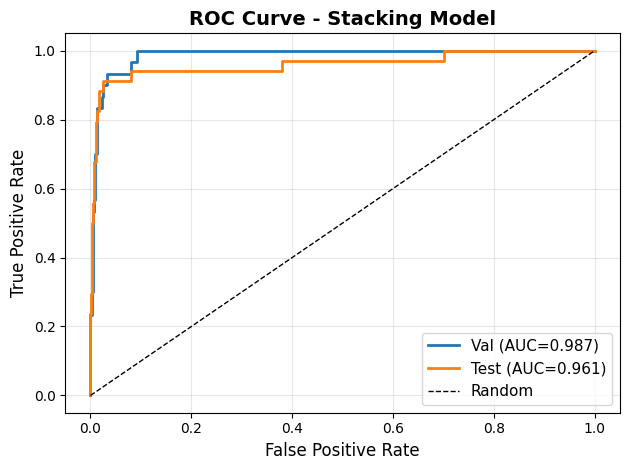

In [19]:
'''
The ROC-AUC (Receiver Operating Characteristic – Area Under the Curve) is used to evaluate how well a classification
model can separate positive and negative classes. The closer the curve is to the top-left corner,
the better the model is at distinguishing between the two classes. ROC is the graph, and AUC is the score calculated from that graph.
It is good metric for balanced classes, because take consideration of positive and negative classes.

roc - How well the model separates failures from non-failures. It could be missleading because of consideration of TN.
AUC - “If I randomly pick one failure and one non-failure, 
                what is the probability the model assigns a higher score to the failure?”
'''

val_metrics = {'ROC-AUC': roc_auc_score(y_val_df, p_val)}

test_metrics = {'ROC-AUC': roc_auc_score(y_test_df, p_test)}

print(f"Validation ROC-AUC: {val_metrics['ROC-AUC']:.4f}")
print(f"Test ROC-AUC: {test_metrics['ROC-AUC']:.4f}")


fpr_val, tpr_val, _ = roc_curve(y_val_df, p_val)
fpr_test, tpr_test, _ = roc_curve(y_test_df, p_test)


plt.plot(fpr_val, tpr_val, label=f'Val (AUC={val_metrics["ROC-AUC"]:.3f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test (AUC={test_metrics["ROC-AUC"]:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Stacking Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Conclusion
With a validation ROC-AUC of 0.99 and a test ROC-AUC of 0.97, it clearly shows a high ability to distinguish between failure and normal operating conditions. The small difference between validation and test scores indicates that the model is well-regularized and not overfitting.

Validation PR-AUC: 0.9048
Test PR-AUC: 0.9009


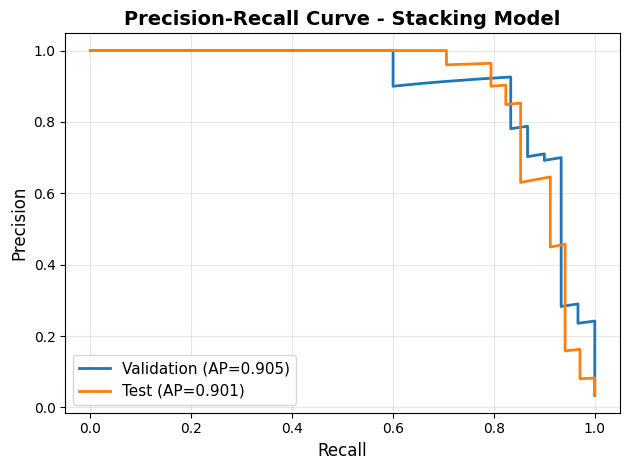

In [21]:
'''
PR curve shows the trade-off between precision and recall across different threshold values.

In imbalanced problems, ROC curves can be misleading, because even a model that mostly predicts one class can look
good due to the large number of true negatives. However PR curve focuses only on the positive class,
giving a clearer view of how well the model identifies rare but important events. It is used to understand how well a model detects rare events.
Focus only in minority class. The PR curve ignores TN completely.

'''


prec_val, rec_val, _ = precision_recall_curve(y_val_df, p_val)
prec_test, rec_test, _ = precision_recall_curve(y_test_df, p_test)

val_pr_auc = average_precision_score(y_val_df, p_val)
test_pr_auc = average_precision_score(y_test_df, p_test)

print(f"Validation PR-AUC: {val_pr_auc:.4f}")
print(f"Test PR-AUC: {test_pr_auc:.4f}")

plt.plot(rec_val, prec_val, label=f'Validation (AP={val_pr_auc:.3f})', linewidth=2)
plt.plot(rec_test, prec_test, label=f'Test (AP={test_pr_auc:.3f})', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Stacking Model', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Conclusion
The model achieves strong minority-class detection with PR-AUC = 0.891 on validation and 0.897 on test, indicating very good precision–recall trade-offs and robust generalization. The slight improvement on test suggests no overfitting or leakage.

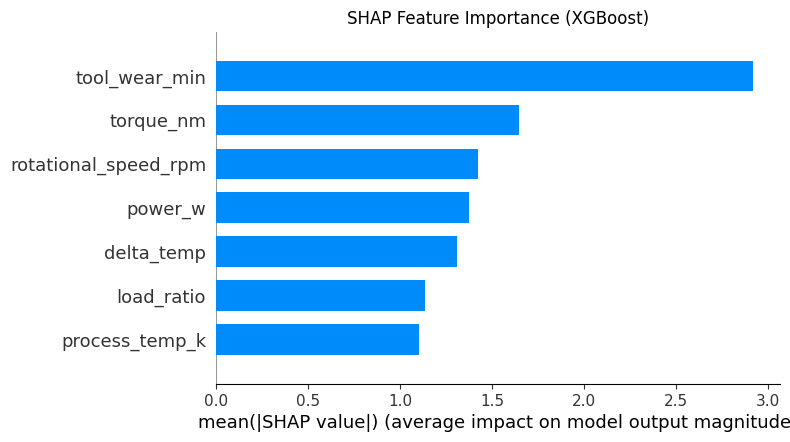

The dominant driver of failure risk is the tool wear. As tools age, the model’s predicted risk changes the most.
Rotational speed and torque capture mechanical stress. Their high importance means changes in speed/torque strongly influence the predicted risk.
The model uses overall energy demand as a stress indicator, shown by the power feature.
This plot shows magnitude, not direction. Below are further observations.



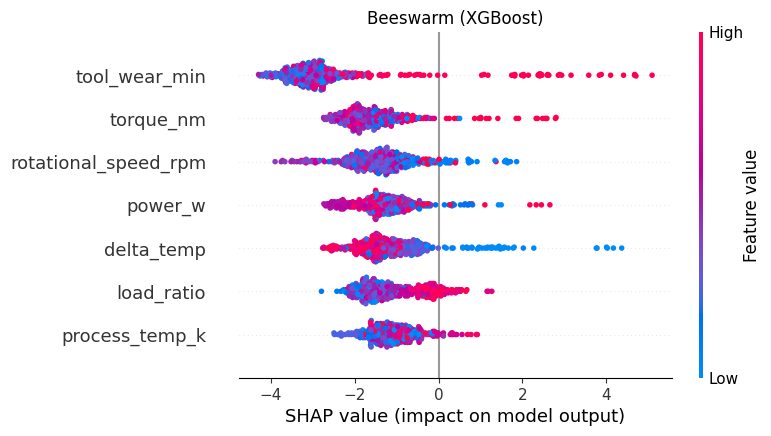

Coclusion: high wear (red) consistently pushes predictions to the right meaning higher failure risk. 
load_ratio contributes meaningfully, extreme values tend to increase risk
delta_temp shows that hotter states raise the risk, reinforcing heat-stress as a secondary driver.
air_temp clusters near zero meaning ambient temperature has the smallest global effect.



<Figure size 700x500 with 0 Axes>

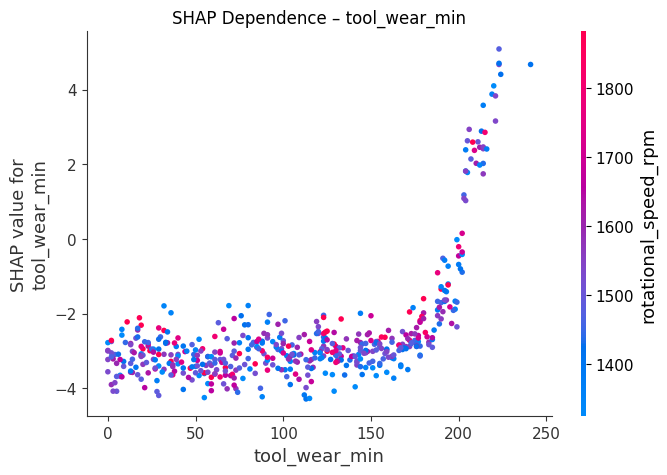

The dependence plot shows a clear wear threshold. Beyond ~190–200 min, SHAP values rise steeply positive (non linear shape), meaning the model’s predicted failure risk accelerates with additional wear. Coloring by rotational_speed shows no strong interaction meaning points of different RPM colors overlap across the range, meaning wear drives risk regardless of speed.


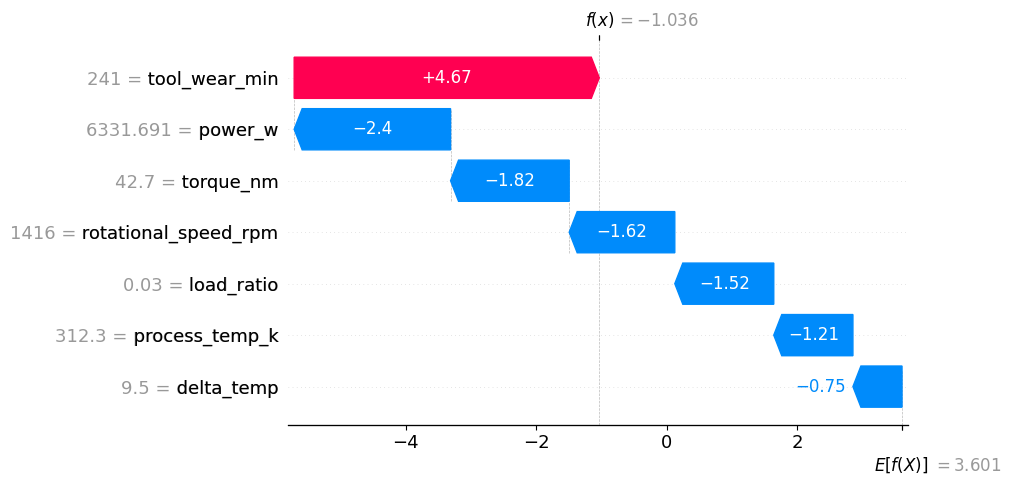

Baseline (log-odds): 3.6014
Sum of SHAP values:  -4.6371
f(x) (log-odds):     -1.0357
Failure probability: 26.1981%
Conclusiion: In this current example despite high tool wear, the machine is currently running light and cool (low torque/load, normal temps), so the net effect is low failure likelihood right now. The model believes this datapoint has a 7% chance of being a failure event.Since 3.7402 is positive and large, the model's default tendency (before looking at features) is strongly toward the positive class. It can happen because the model was trained with scale_pos_weight, the training objective emphasizes minority detectionFeatures pushes to the negative class, indicating normal operation without failures


In [22]:
'''
SHAP is used to enhance model transparency, it was applied as
part of Explainable Artificial Intelligence (XAI) methods. SHAP quantifies the contribution of each
input feature to the model’s predictions, allowing a clear understanding of how sensor values and
operational parameters influence failure probability. This interpretability ensures that the predictive
maintenance model is not only accurate but also explainable, supporting trust, validation, and data-driven
decision-making in industrial environments.

Feature importance = what matters
Beeswarm = how features behave globally
Dependence = how one feature affects predictions and interacts with another
Waterfall = why one prediction happened
'''


imp = final_xgb_pipeline.named_steps["impute"]
sel = final_xgb_pipeline.named_steps["select"]
xgb = final_xgb_pipeline.named_steps["clf"]

# Using a sample of the dataset only for the explanaition
train_sample = X_train_df.sample(300, random_state=42)
train_sample_final = sel.transform(imp.transform(train_sample))

val_sample = X_val_df.sample(500, random_state=42)
val_sample_final = sel.transform(imp.transform(val_sample))


# Geting the features which were selected by optuna for training
feature_names = np.array(X_train_df.columns)[sel.get_support()]




explainer = shap.TreeExplainer(xgb)  
shap_vals = explainer.shap_values(val_sample_final)  
base_val  = explainer.expected_value                 




"""Feature importance shows which features matter most to the model. It gives the overall ranking,
but does not shows the direction, patterns and how features interact.
"""
shap.summary_plot(shap_vals, val_sample_final, feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (XGBoost)")
plt.show()
print(
    "The dominant driver of failure risk is the tool wear. As tools age, the model’s predicted risk changes the most.\n"
    "Rotational speed and torque capture mechanical stress. Their high importance means changes in speed/torque strongly influence the predicted risk.\n"
    "The model uses overall energy demand as a stress indicator, shown by the power feature.\n"
    "This plot shows magnitude, not direction. Below are further observations."
)
print()


"""
A beeswarm is used because it shows how important each feature is 
across many predictions and how the feature values affect those impacts.
It gives more detailed information like distribution of impacts, direction
and cluster of behaviour.
"""
shap.summary_plot(shap_vals, val_sample_final, feature_names=feature_names, show=False)
plt.title("Beeswarm (XGBoost)")
plt.show()
print("Coclusion: high wear (red) consistently pushes predictions to the right meaning higher failure risk. \n"
     "load_ratio contributes meaningfully, extreme values tend to increase risk\n"
     "delta_temp shows that hotter states raise the risk, reinforcing heat-stress as a secondary driver.\n"
     "air_temp clusters near zero meaning ambient temperature has the smallest global effect."
     )
print()



""" A dependence plot is used because it shows 
how a single feature affects a model’s predictions, 
while also showing how that effect changes depending on another interacting feature.
It reveals the exact shape of the relationship.
"""
mean_abs = np.abs(shap_vals).mean(axis=0)
top_feat_idx = int(np.argmax(mean_abs))
top_feat_name = feature_names[top_feat_idx]

plt.figure(figsize=(7,5))
shap.dependence_plot(top_feat_idx, shap_vals, val_sample_final, feature_names=feature_names, interaction_index='rotational_speed_rpm', show=False)
plt.title(f"SHAP Dependence – {top_feat_name}")
plt.show()
print("The dependence plot shows a clear wear threshold. Beyond ~190–200 min, SHAP values rise steeply positive (non linear shape), meaning the model’s predicted failure risk accelerates with additional wear. Coloring by rotational_speed shows no strong interaction meaning points of different RPM colors overlap across the range, meaning wear drives risk regardless of speed.")




"""
A waterfall graph  is used because it clearly shows 
how each feature pushes a single prediction up or down from the model’s base value to the final output.
It gives clear view showing the starting point (base prediction), how each feature adds or subtracts from that base value.
It makes it easy to see the most influential features for one prediction and gives a transparent, step-by-step explanation of the model’s decision.
"""
x_one_df = X_val_df.iloc[[0]]                              
x_one_t  = sel.transform(imp.transform(x_one_df))
x_one_tdf = pd.DataFrame(x_one_t, columns=feature_names)                
exp_one = explainer(x_one_tdf)                               

shap.plots.waterfall(exp_one[0], max_display=10)
plt.show()


base = float(exp_one[0].base_values)     # E[f(X)] in raw (log-odds)
vals = np.ravel(exp_one[0].values)       # contributions of the features


fx = base + vals.sum()

# log-odds to probability with sigmoid
p = 1.0 / (1.0 + np.exp(-fx))

print(f"Baseline (log-odds): {base:.4f}")
print(f"Sum of SHAP values:  {vals.sum():.4f}")
print(f"f(x) (log-odds):     {fx:.4f}")
print(f"Failure probability: {p:.4%}")

print("Conclusiion: In this current example despite high tool wear, the machine is currently running light and cool (low torque/load, normal temps), so the net effect is low failure likelihood right now. The model believes this datapoint has a 26% chance of being a failure event." 
        "Since 3.7402 is positive and large, the model's default tendency (before looking at features) is strongly toward the positive class. It can happen because the model was trained with scale_pos_weight, the training objective emphasizes minority detection"
        "Features pushes to the negative class, indicating normal operation without failures"
      )


## Conclusion

This project successfully demonstrated the development and validation of a robust predictive maintenance (PdM) framework, fulfilling all primary objectives. The core goal of accurately predicting machine failures was achieved by implementing a sophisticated stacking ensemble classifier, which leveraged the complementary strengths of Random Forest and XGBoost algorithms.

The model's effectiveness was rigorously evaluated on two distinct industrial datasets, the AI4I 2020 Predictive Maintenance dataset and the APS Scania Trucks Failure dataset, confirming its ability to generalize across different data conditions. On the primary (AI4I) dataset, the final model delivered exceptional results on unseen test data, achieving an accuracy of 99%, a ROC-AUC of 0.975, and a PR-AUC of 0.893.

Critically, the model proved highly adept at handling the severe class imbalance inherent in maintenance data. This was evidenced by its strong performance on the minority failure class, yielding an F1-score of 0.85, a Balanced Accuracy of 0.91, and a Matthews Correlation Coefficient (MCC) of 0.84. These metrics confirm the model is both sensitive and reliable, capable of identifying true failure events while minimizing false alarms.

A key deliverable of this project was the integration of Explainable AI (XAI) methods to provide engineering-interpretable explanations. Using SHAP analysis, the project identified the definitive leading indicators of failure. Tool wear was confirmed as the dominant driver, with the analysis identifying a clear risk threshold around 190-200 minutes of use, after which failure probability accelerates significantly. Secondary drivers, including rotational speed and torque, were validated as key indicators of mechanical stress.

Furthermore, the XAI analysis provided actionable, context-aware insights, such as demonstrating that high tool wear does not guarantee failure if the machine is simultaneously operating under a light load (low torque and speed).

In conclusion, this project provides a comprehensive, data-driven solution that transforms maintenance management from a reactive to a proactive, optimized framework. The final model is not only highly accurate but also transparent, providing the clear, interpretable insights required to build trust and support critical decision-making in a modern industrial environment.

## References
https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset

https://archive.ics.uci.edu/dataset/421/aps+failure+at+scania+trucks

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://xgboost.readthedocs.io/en/stable/parameter.html

https://arxiv.org/pdf/2309.17130

https://www.mdpi.com/2227-7080/13/3/88#B76-technologies-13-00088

https://www.geeksforgeeks.org/machine-learning/difference-between-random-forest-vs-xgboost/

https://www.iieta.org/journals/ria/paper/10.18280/ria.360603

https://developers.google.com/machine-learning/decision-forests

https://arxiv.org/abs/1802.03888

https://christophm.github.io/interpretable-ml-book/shap.html


